In [1]:
import torch
from torch.nn import DataParallel
from torch.utils.data import DataLoader
from torch.optim import AdamW
from scipy.optimize import minimize, fsolve
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
import os
import gc
from tqdm import tqdm
import sys
sys.path.append("../src")
from config import read_config, update_config
from metric import cal_mae_metric
from dataset import read_data
from util import smart_avg

In [2]:
config = read_config("Base")
config.gpu = [0]
config = update_config(config)

Using device: cuda
Number of device: 1
Model Output Folder: /home/vincent/Kaggle/GBVPP/output/Base/


In [14]:
subs = {
    "LSTM5_REG_physics_PL_better_2": "../output/LSTM5_REG_physics_PL_better_2/test_pred_all_17501.csv",
    "Public_PulpFriction_New": "../output/Public_PulpFriction_New/test_pred_all_16657.csv",
    #"LSTM5_CLS_DO03_CH02_IPOnly_SiLU_ADAM_PL3":"../output/LSTM5_CLS_DO03_CH02_IPOnly_SiLU_ADAM_PL3/test_pred_all_17404.csv"
}
ensemble_folder = config.output_folder + "/" + "ensemble_1101_2Model"
if not os.path.exists(ensemble_folder):
    
    os.makedirs(ensemble_folder)

In [15]:
train, test = read_data(config)

In [16]:
pressure_unique = np.load("/home/vincent/Kaggle/GBVPP/input/pressure_unique.npy")

In [17]:
P_MIN = np.min(pressure_unique)
P_MAX = np.max(pressure_unique)
P_STEP = pressure_unique[1] - pressure_unique[0]
def transform_p(x):
    t = ((x - P_MIN) // P_STEP * P_STEP + P_MIN)
    return min(max(t, P_MIN), P_MAX)

def transform_pv(s):
    t = ((s - P_MIN) // P_STEP * P_STEP + P_MIN)
    return np.clip(t, P_MIN, P_MAX)

In [18]:
sub_all = None
for key, sub_file in tqdm(subs.items()):
    train[key] = 0
    tmp = pd.read_csv(sub_file)
    if sub_all is None:
        sub_all = tmp[["id","pressure"]].copy()
        sub_all["pressure"] = 0
        
    for fold in range(5):
        if "Public_PulpFriction_New" == key:
            train.loc[train.query(f"fold=={fold}").index, key] = np.load(f'../output/{key}/oof{fold}.npy').flatten()
        else:
            train.loc[train.query(f"fold=={fold}").index, key] = torch.load(f'../output/{key}/Fold_{fold}_best_model.pth')['valid_preds'].flatten()
        sub_all[key+f"_{fold}"] = tmp[f"preds_fold{fold}"]
    sub_all[key] = smart_avg(sub_all[[key+f"_{f}" for f in range(5)]],axis=1)
    sub_all[key] = sub_all[key].apply(transform_p)

  0%|                                                                                     | 0/2 [00:00<?, ?it/s]

Inliers:  3909208 -> compute mean
Outliers:  114792 -> compute median
Total:    4024000


 50%|██████████████████████████████████████▌                                      | 1/2 [00:05<00:05,  5.61s/it]

Inliers:  3565273 -> compute mean
Outliers:  458727 -> compute median
Total:    4024000


100%|█████████████████████████████████████████████████████████████████████████████| 2/2 [00:11<00:00,  5.56s/it]


In [22]:
train.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure,fold,LSTM5_REG_physics_PL_better_2,Public_PulpFriction_New,pressure_smart
0,1,1,20,50,0.000000,0.083334,0,5.837492,4,5.767190,5.813899,5.767190
1,2,1,20,50,0.033652,18.383041,0,5.907794,4,5.837492,5.973472,5.907794
2,3,1,20,50,0.067514,22.509277,0,7.876254,4,7.946556,8.012121,7.946556
3,4,1,20,50,0.101542,22.808823,0,11.742872,4,11.813173,11.873021,11.813174
4,5,1,20,50,0.135756,25.355850,0,12.234987,4,12.516195,12.394066,12.445893


In [23]:
sub_all.head()

,id,pressure,LSTM5_REG_physics_PL_better_2_0,LSTM5_REG_physics_PL_better_2_1,LSTM5_REG_physics_PL_better_2_2,LSTM5_REG_physics_PL_better_2_3,LSTM5_REG_physics_PL_better_2_4,LSTM5_REG_physics_PL_better_2,Public_PulpFriction_New_0,Public_PulpFriction_New_1,Public_PulpFriction_New_2,Public_PulpFriction_New_3,Public_PulpFriction_New_4,Public_PulpFriction_New
0,1,6.189002,6.329606,6.259304,6.259304,6.259304,6.189002,6.189002,6.297967,6.315374,6.320640,6.227913,6.300588,6.259305
1,2,5.907794,5.978096,5.978096,5.907794,5.907794,5.907794,5.907794,5.987489,5.982381,5.996212,5.917186,5.982573,5.907794
2,3,7.032628,7.032628,7.102930,7.173232,7.102930,7.102930,7.032628,7.048677,7.147728,7.079803,7.086129,7.157315,7.102930
3,4,7.524743,7.595045,7.665347,7.524743,7.595045,7.595045,7.524743,7.596078,7.761950,7.575807,7.577055,7.637226,7.595045
4,5,9.001088,9.071390,9.141692,9.001088,9.071390,9.071390,9.001088,9.124584,9.207625,9.030670,9.131549,9.165101,9.071390


In [24]:
id_score = train.groupby("breath_id").apply(lambda df: cal_mae_metric(df["pressure"],df["pressure_smart"],1-df["u_out"]))

In [27]:
id_score.describe()

count    75450.000000
mean         0.158526
std          0.248364
min          0.002343
25%          0.063499
50%          0.096080
75%          0.159998
max         19.703528
dtype: float64

In [32]:
np.sum(id_score > 1)

984

In [30]:
len(id_score)

75450

In [37]:
drop_id_1 = np.array(id_score[id_score > 1].index)
drop_id_2 = np.array(id_score[id_score > 2].index)
np.save("../input/large_error_id_1", drop_id_1)
np.save("../input/large_error_id_2", drop_id_2)

['LSTM5_REG_physics_PL_better_2', 'Public_PulpFriction_New'] (6036000, 5)
Inital Blend OOF: -0.164781
Optimised Blend OOF: -0.159634
----------------------------------------------------------------------
LSTM5_REG_physics_PL_better_2            Optimised Weights: 0.36341257205255006
Public_PulpFriction_New                  Optimised Weights: 0.6382675562859392


<AxesSubplot:>

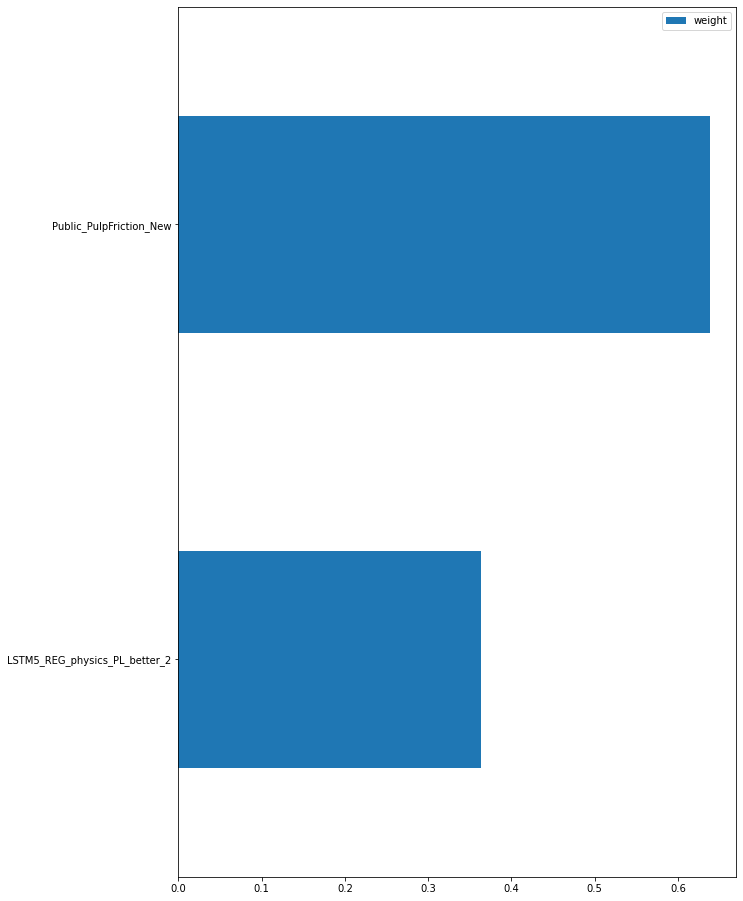

In [19]:
# weight optimization here .....
model_cols = list(subs.keys())
sci_opt_preds = train[model_cols + ["pressure","u_out","fold"]].copy() 
X = sci_opt_preds[model_cols].values
print(model_cols, sci_opt_preds.shape)
def get_score(weights, oof=sci_opt_preds):
    weights = np.array(weights)
    oof["prediction"] = (weights * X).sum(axis=1)
    oof["prediction"] = transform_pv(oof["prediction"])
    return oof.groupby("fold").apply(lambda df: cal_mae_metric(df["pressure"],df["prediction"],1-df["u_out"])).mean()

tol = 1e-10
init_guess = [1 / len(model_cols)] * len(model_cols)
bnds = [(-1, 1) for _ in range(len(model_cols))]
print('Inital Blend OOF: {:.6f}'.format(-get_score(init_guess)))
res_scipy = minimize(fun = get_score, 
                    x0 = init_guess, 
                    method = 'Nelder-Mead', 
                    bounds = bnds, 
                    tol = tol)
print('Optimised Blend OOF: {:.6f}'.format(-res_scipy.fun))
sci_cv_score = -res_scipy.fun
print('-' * 70)
for n, key in enumerate(model_cols):
    print(f'{key:40s} Optimised Weights:', res_scipy.x[n])
ws = res_scipy.x 
pd.DataFrame(dict(zip(model_cols,ws)),index=["weight"]).T.plot(kind="barh",figsize=(10,16))

In [20]:
# weights here ....        
train["pressure_smart"] = transform_pv((train[list(subs.keys())] * ws).sum(axis=1))
CVs = train.groupby("fold").apply(lambda df: cal_mae_metric(df["pressure"],df["pressure_smart"],1-df["u_out"]))
CV = np.mean(CVs)
print(CVs)
print("Ensemble CV: Mean {:.4f}, std {:.4f}".format(np.mean(CVs), np.std(CVs)))

fold
0    0.162597
1    0.158854
2    0.156994
3    0.159313
4    0.160414
dtype: float64
Ensemble CV: Mean 0.1596, std 0.0018


In [21]:
for fold in tqdm(range(5)):
    sub_keys = [key+f"_{fold}" for key in subs.keys()]
    test_fold_pred = transform_pv((sub_all[sub_keys] * ws).sum(axis=1))
    sub_fold = sub_all[["id"]].copy()
    sub_fold[f'preds_fold{fold}'] = test_fold_pred
    sub_fold.to_csv(ensemble_folder + f"/test_fold{fold}.csv",index=False)

sub_all["pressure"] = transform_pv((sub_all[model_cols] * ws).sum(axis=1))
sub_all.to_csv(ensemble_folder + f"/sub_all_{CV*1e5:.0f}.csv")
sub_all[["id","pressure"]].to_csv(ensemble_folder + f"/submission_{CV*1e5:.0f}.csv",index=False)
print(sub_all.shape, train.shape)
sub_all

100%|█████████████████████████████████████████████████████████████████████████████| 5/5 [00:28<00:00,  5.76s/it]


(4024000, 14) (6036000, 12)


,id,pressure,LSTM5_REG_physics_PL_better_2_0,LSTM5_REG_physics_PL_better_2_1,LSTM5_REG_physics_PL_better_2_2,LSTM5_REG_physics_PL_better_2_3,LSTM5_REG_physics_PL_better_2_4,LSTM5_REG_physics_PL_better_2,Public_PulpFriction_New_0,Public_PulpFriction_New_1,Public_PulpFriction_New_2,Public_PulpFriction_New_3,Public_PulpFriction_New_4,Public_PulpFriction_New
0,1,6.189002,6.329606,6.259304,6.259304,6.259304,6.189002,6.189002,6.297967,6.315374,6.320640,6.227913,6.300588,6.259305
1,2,5.907794,5.978096,5.978096,5.907794,5.907794,5.907794,5.907794,5.987489,5.982381,5.996212,5.917186,5.982573,5.907794
2,3,7.032628,7.032628,7.102930,7.173232,7.102930,7.102930,7.032628,7.048677,7.147728,7.079803,7.086129,7.157315,7.102930
3,4,7.524743,7.595045,7.665347,7.524743,7.595045,7.595045,7.524743,7.596078,7.761950,7.575807,7.577055,7.637226,7.595045
4,5,9.001088,9.071390,9.141692,9.001088,9.071390,9.071390,9.001088,9.124584,9.207625,9.030670,9.131549,9.165101,9.071390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4023995,4023996,3.869032,0.002414,0.002414,0.002414,0.002414,0.002414,-0.067889,6.155486,6.287960,6.178166,6.289627,6.211693,6.189002
4023996,4023997,3.939334,0.002414,0.002414,0.002414,0.002414,0.002414,-0.067889,6.349664,6.205312,6.254850,6.213360,6.290364,6.259305
4023997,4023998,4.009636,0.002414,0.002414,0.002414,0.002414,0.002414,-0.067889,6.351519,6.484034,6.444641,6.469348,6.476368,6.399909
4023998,4023999,3.869032,0.002414,0.002414,0.002414,0.002414,0.002414,-0.067889,6.155175,6.271890,6.167885,6.279932,6.199571,6.189002
